In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import *
import itertools
from tqdm import tqdm
#from google.colab import files

In [2]:
tf.__version__

'2.4.1'

# **Reading Data**

In [3]:
players = pd.read_excel('players (extension).xlsx', index_col = 0)

In [4]:
players.head()

,Name,Country,Current Rating,Potential Rating,Height (cm),Weight (kg),Preferred Foot,Birth Date,Age,Preferred Positions,...,FK Acc.,Penalties,Volleys,GK Positioning,GK Diving,GK Handling,GK Kicking,GK Reflexes,Specialities,Traits
0,Lionel Messi,Argentina,94,94,170,72,Left,"June 24, 1987",33,RW ST CF,...,94,75,88,14,6,11,15,8,"Dribbler, Distance Shooter, Crosser, FK Specia...","Finesse Shot, Long Shot Taker (CPU AI Only), S..."
1,Cristiano Ronaldo,Portugal,93,93,187,83,Right,"Feb. 5, 1985",35,ST LW,...,76,85,87,14,7,11,15,11,"Dribbler, Distance Shooter, Acrobat, Clinical ...","Power Free-Kick, Flair, Long Shot Taker (CPU A..."
2,Neymar Jr,Brazil,92,92,175,68,Right,"Feb. 5, 1992",28,LW CAM,...,89,92,87,15,9,9,15,11,"Speedster, Dribbler, Playmaker, Crosser, FK Sp...","Injury Prone, Flair, Speed Dribbler (CPU AI On..."
3,Virgil van Dijk,Netherlands,91,92,193,92,Right,"July 8, 1991",29,CB,...,70,62,45,11,13,10,13,11,"Tackling, Tactician, Strength, Complete Defender","Leadership, Long Passer (CPU AI Only), Power H..."
4,Jan Oblak,Slovenia,91,93,188,87,Right,"Jan. 7, 1993",27,GK,...,14,11,13,90,87,92,78,89,No,"GK Long Throw, Comes For Crosses"


In [5]:
players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2940 entries, 0 to 2939
Data columns (total 57 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Name                 2940 non-null   object
 1   Country              2940 non-null   object
 2   Current Rating       2940 non-null   int64 
 3   Potential Rating     2940 non-null   int64 
 4   Height (cm)          2940 non-null   int64 
 5   Weight (kg)          2940 non-null   int64 
 6   Preferred Foot       2940 non-null   object
 7   Birth Date           2940 non-null   object
 8   Age                  2940 non-null   int64 
 9   Preferred Positions  2940 non-null   object
 10  Player Work Rate     2940 non-null   object
 11  Weak Foot            2940 non-null   int64 
 12  Skill Moves          2940 non-null   int64 
 13  Value (€)            2940 non-null   int64 
 14  Wage (€)             2940 non-null   int64 
 15  Team                 2940 non-null   object
 16  Positi

# **Preprocessing**

In [6]:
# creating X-matrix and Y-vector
x = players.loc[:, ['Current Rating',	'Potential Rating',	'Height (cm)',	'Weight (kg)', 'Age', 'Weak Foot',	'Skill Moves', 'Wage (€)', 'Contract Length',
                    'Ball Control', 'Dribbling', 'Marking', 'Slide Tackle', 'Stand Tackle', 'Aggression', 'Reactions', 'Att. Position', 'Interceptions',
                    'Vision',	'Composure', 'Crossing', 'Short Pass', 'Long Pass',	'Acceleration',	'Stamina', 'Strength',	'Balance', 'Sprint Speed', 'Agility',
                    'Jumping', 'Heading', 'Shot Power',	'Finishing', 'Long Shots', 'Curve',	'FK Acc.', 'Penalties', 'Volleys', 'GK Positioning', 'GK Diving',
                    'GK Handling', 'GK Kicking', 'GK Reflexes']].values.copy()
y = players.loc[:, 'Value (€)'].values.copy()

In [7]:
# normalization of the matrix X
scaler = StandardScaler().fit(x)
x_scaled = scaler.transform(x)

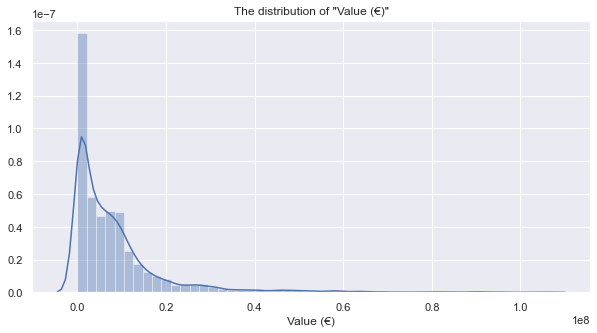

In [8]:
plt.figure(figsize = (10, 5))
sns.distplot(a = players['Value (€)'])
plt.title('The distribution of "Value (€)"')
plt.show()

In [9]:
# normalization of the vector Y
y = y / 1000000

# **Modeling**

In [10]:
# train, validation and test splits
x_train, x_val_test, y_train, y_val_test = train_test_split(x_scaled, y, test_size = 0.2, random_state = 42)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size = 0.5, random_state = 42)
# conver to tensor
## train data
tensor_x_train = tf.convert_to_tensor(value = x_train, dtype = tf.float32)
tensor_y_train = tf.convert_to_tensor(value = y_train, dtype = tf.float32)
## validation data
tensor_x_val = tf.convert_to_tensor(value = x_val, dtype = tf.float32)
tensor_y_val = tf.convert_to_tensor(value = y_val, dtype = tf.float32)
## test data
tensor_x_test = tf.convert_to_tensor(value = x_test, dtype = tf.float32)
tensor_y_test = tf.convert_to_tensor(value = y_test, dtype = tf.float32)

# reshape y vectors for CustomLoss
tensor_y_train = tf.reshape(tensor_y_train, shape = [len(tensor_y_train), 1])
tensor_y_val = tf.reshape(tensor_y_val, shape = [len(tensor_y_val), 1])
tensor_y_test = tf.reshape(tensor_y_test, shape = [len(tensor_y_test), 1])

### Regression

In [11]:
def CustomLoss(y, yhat):
    return tf.math.reduce_mean(tf.math.square(tf.subtract(y, yhat))) 

In [12]:
neurons = [40, 40]
activation = 'relu'
learning_rate = 1e-3
batch_size = 256
epochs = 100
lmbda = 0.

# model
model = Sequential()
## layers
model.add(layers.Input(shape = tensor_x_train.shape[1], ))
for neuron in neurons:
    if activation == 'tanh':
        model.add(layers.Dense(neuron, activation = activation, kernel_initializer = initializers.HeNormal(),
                               kernel_regularizer = regularizers.l2(lmbda)))
    elif activation == 'relu':
        model.add(layers.Dense(neuron, activation = activation, kernel_initializer = initializers.GlorotNormal(),
                               kernel_regularizer = regularizers.l2(lmbda)))
    else:
        raise Exception('"activation" must be either relu or tanh')
model.add(layers.Dense(1, activation = 'relu'))
## compile model
model.compile(
    optimizer = 'adam',
    loss = CustomLoss
)
## train model
results = model.fit(tensor_x_train, tensor_y_train, batch_size = batch_size, epochs = epochs, verbose = 0)

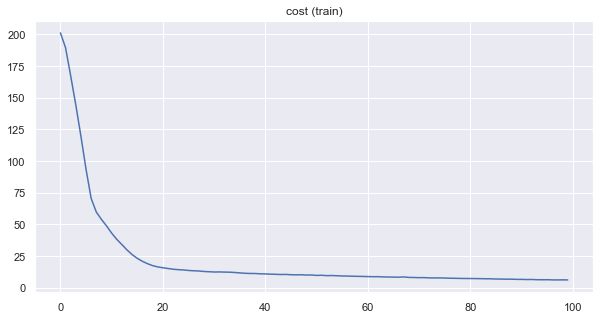

In [13]:
plt.figure(figsize = (10, 5))
plt.plot(results.history['loss'])
plt.title('cost (train)')
plt.show()

In [14]:
print('rsquare for train set:', r2_score(model.predict(tensor_x_train), tensor_y_train))
print('rsquare for val set:', r2_score(model.predict(tensor_x_val), tensor_y_val))
print('rsquare for test set:', r2_score(model.predict(tensor_x_test), tensor_y_test))

rsquare for train set: 0.9520413449038169
rsquare for val set: 0.9266690474686531
rsquare for test set: 0.966527471917382


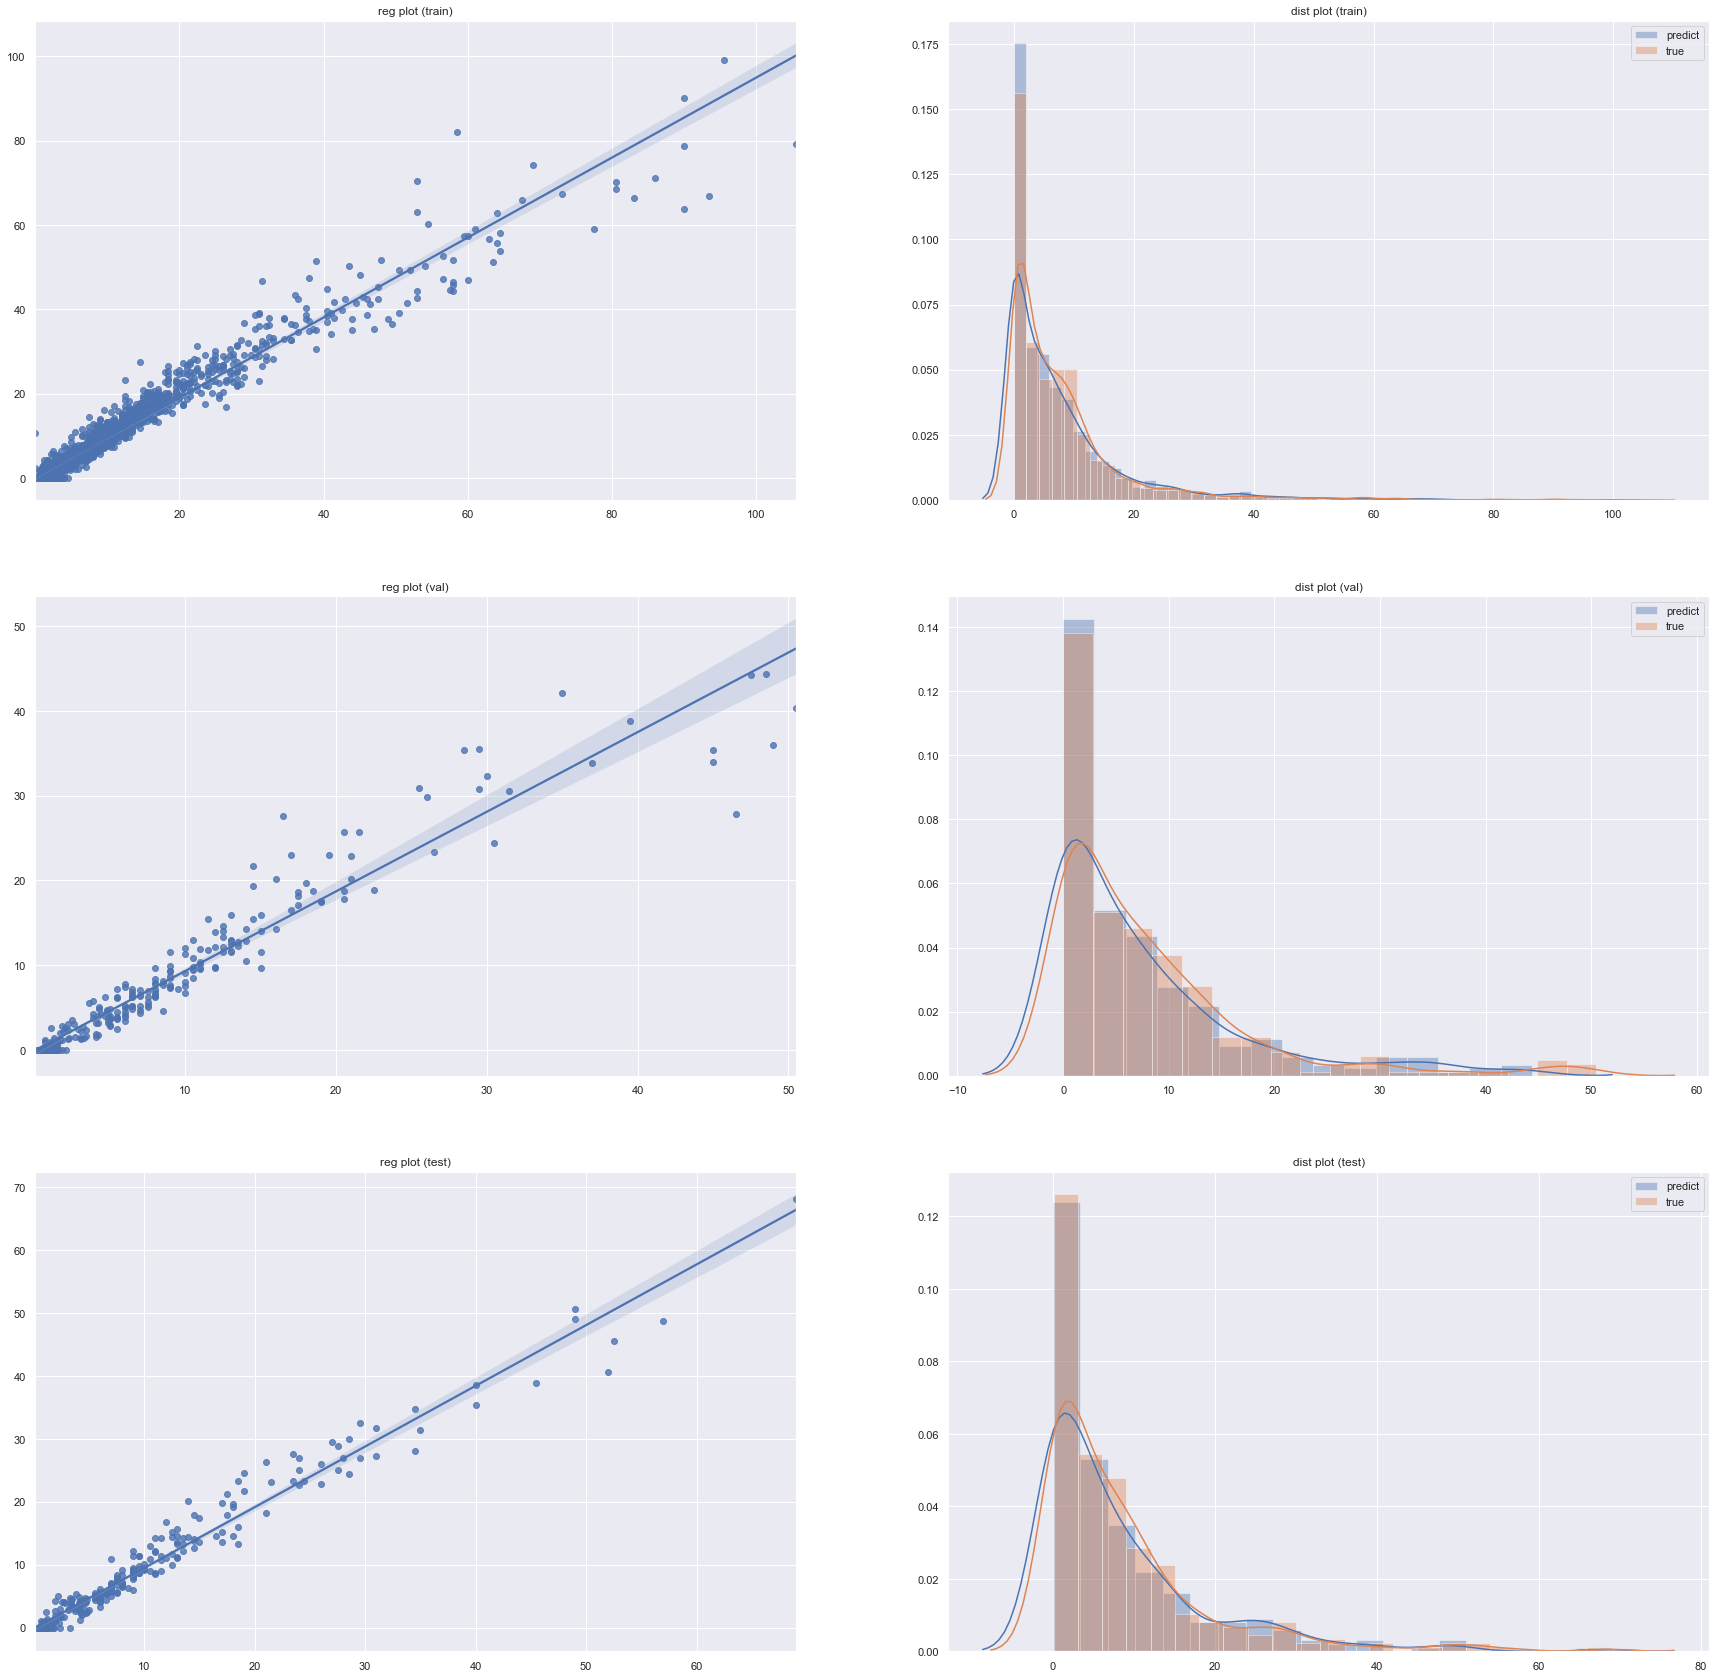

In [15]:
fig, ax = plt.subplots(3, 2, figsize = (30, 30))

# train
## regplot
sns.regplot(x = tensor_y_train, y = model.predict(tensor_x_train), ax = ax[0][0])
ax[0][0].set_title('reg plot (train)')
## distplot
sns.distplot(model.predict(tensor_x_train), label = 'predict', ax = ax[0][1])
sns.distplot(tensor_y_train, label = 'true', ax = ax[0][1])
ax[0][1].set_title('dist plot (train)')
ax[0][1].legend()

# val
## regplot
sns.regplot(x = tensor_y_val, y = model.predict(tensor_x_val), ax = ax[1][0])
ax[1][0].set_title('reg plot (val)')
## distplot
sns.distplot(model.predict(tensor_x_val), label = 'predict', ax = ax[1][1])
sns.distplot(tensor_y_val, label = 'true', ax = ax[1][1])
ax[1][1].set_title('dist plot (val)')
ax[1][1].legend()

# test
## regplot
sns.regplot(x = tensor_y_test, y = model.predict(tensor_x_test), ax = ax[2][0])
ax[2][0].set_title('reg plot (test)')
## distplot
sns.distplot(model.predict(tensor_x_test), label = 'predict', ax = ax[2][1])
sns.distplot(tensor_y_test, label = 'true', ax = ax[2][1])
ax[2][1].set_title('dist plot (test)')
ax[2][1].legend()

plt.show()